<h1>This notebook has been created as a part of the Coursera Capstone Project 
for the IBM Data Science Professional Certificate </h1>

In [1]:
#Importing all the libraries that will be needed to carry out the study 
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json #process json

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.preprocessing import StandardScaler #Normalize datasets

print('Libraries imported.')

Libraries imported.


<h3>Purpose of this notebook : Explore and Cluster the residential comunities in Calgary, Alberta, Canada.</h3>
<h4>Immigrants to Canada, who are looking to settle down in Calgary, or residents who are looking to move will be able to use the information presented in this analysis to determine similar groups of neighborhoods which meet their criteria. The criteria will include crime rates, housing prices, popular venues and availability of public schools</h4>

<h4>Step 1 : Get the list of the community points of the city of Calgary using open data maintained by the city </h4>

    

In [3]:
calgary_communities_df = pd.read_csv('https://data.calgary.ca/api/views/j9ps-fyst/rows.csv')
print(calgary_communities_df.shape)
calgary_communities_df.head()

(309, 10)


,CLASS,CLASS_CODE,COMM_CODE,NAME,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location
0,Residential,1,THS,TWINHILLS,EAST,DEVELOPING,BUILDING OUT,-113.877110,51.045111,"(51.045111353378694, -113.87710975220665)"
1,Residential,1,WIL,WILLOW PARK,SOUTH,BUILT-OUT,1960s/1970s,-114.056204,50.956623,"(50.95662292848714, -114.05620363150967)"
2,Residual Sub Area,4,05D,05D,NORTHEAST,NaN,UNDEVELOPED,-113.958662,51.179598,"(51.17959764644064, -113.95866183876556)"
3,Industrial,2,ST4,STONEY 4,NORTHEAST,NaN,EMPLOYMENT,-114.002762,51.176204,"(51.17620448693238, -114.00276157771617)"
4,Residential,1,PKH,PARKHILL,CENTRE,BUILT-OUT,1950s,-114.065552,51.018181,"(51.01818071993347, -114.06555236114401)"


In [4]:
#Filter out all non-residential communities from the obtained dataframe, keeping only the residential for further processing
#Note that CLASS_CODE = 1 denotes residential communities

cgr_res_df = calgary_communities_df[calgary_communities_df['CLASS_CODE']==1]
print(cgr_res_df.shape)
cgr_res_df.head()

(218, 10)


,CLASS,CLASS_CODE,COMM_CODE,NAME,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location
0,Residential,1,THS,TWINHILLS,EAST,DEVELOPING,BUILDING OUT,-113.877110,51.045111,"(51.045111353378694, -113.87710975220665)"
1,Residential,1,WIL,WILLOW PARK,SOUTH,BUILT-OUT,1960s/1970s,-114.056204,50.956623,"(50.95662292848714, -114.05620363150967)"
4,Residential,1,PKH,PARKHILL,CENTRE,BUILT-OUT,1950s,-114.065552,51.018181,"(51.01818071993347, -114.06555236114401)"
5,Residential,1,PAT,PATTERSON,WEST,BUILT-OUT,1980s/1990s,-114.177047,51.063838,"(51.06383775082155, -114.17704650860274)"
6,Residential,1,RCK,ROSSCARROCK,WEST,BUILT-OUT,1950s,-114.145495,51.043280,"(51.04328023810093, -114.14549516107789)"


<h4>Step 2 : Indicate the communities on a map of the city Calgary  </h4>

<h6>Communities indicated on the map will be labelled according to the clusters they are found to belong to, as determined by the features we are about to explore</h6>

In [6]:
address = 'Calgary, Alberta'

geolocator = Nominatim(user_agent="cgr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary, Alberta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary, Alberta are 51.0534234, -114.0625892.


<h4>Creating a map of Calgary with the communities indicated as dots/small blue circles.</h4>

In [7]:
# create map of New York using latitude and longitude values
map_cgr = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, sector in zip(cgr_res_df['latitude'], cgr_res_df['longitude'], cgr_res_df['NAME'], cgr_res_df['SECTOR']):
    label = '{}'.format(name + ':' + sector)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cgr)  
    
map_cgr

<h6>Step 3 : Put together the data for all the features that will be used to cluster the communities.</h6>
<h6>Feature 1 : Find the most popular venues for all the selected neighbourhoods in Calgary. Now utilizing the foursquare API to explore all of the communities and segment them.</h6>

In [8]:
CLIENT_ID = '0BJZVGGQQXDW2QKNUGYZYMKZQI52VMZHFAIOAPLYZ40URZTG' # my Foursquare ID
CLIENT_SECRET = 'IO5V5W33ZV0XS5QI1CUBNOBU4TPU33FCA3I2X54QL1MSR4YE' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: 0BJZVGGQQXDW2QKNUGYZYMKZQI52VMZHFAIOAPLYZ40URZTG
CLIENT_SECRET:IO5V5W33ZV0XS5QI1CUBNOBU4TPU33FCA3I2X54QL1MSR4YE


In [9]:
#Read the json file returned by the request to foursquare api to create a dataframe consisting
#of the names of the communities and their venues
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NAME', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
# Now finding all the Calgary venues
cgr_venues = getNearbyVenues(names=cgr_res_df['NAME'],
                                   latitudes=cgr_res_df['latitude'],
                                   longitudes=cgr_res_df['longitude']
                                  )

TWINHILLS
WILLOW PARK
PARKHILL
PATTERSON
ROSSCARROCK
ACADIA
SHAWNEE SLOPES
MACEWAN GLEN
ELBOW PARK
GLENBROOK
KEYSTONE HILLS
ROCKY RIDGE
DOWNTOWN WEST END
DEER RIDGE
ERLTON
SILVER SPRINGS
SIGNAL HILL
WOLF WILLOW
ROSEMONT
SHAGANAPPI
SCARBORO/ SUNALTA WEST
COUGAR RIDGE
DALHOUSIE
SUNALTA
TEMPLE
LEWISBURG
ABBEYDALE
KINCORA
MAPLE RIDGE
RIVERBEND
PARKDALE
PINERIDGE
HOTCHKISS
DOWNTOWN EAST VILLAGE
EVERGREEN
COVENTRY HILLS
KINGSLAND
FOREST LAWN
MANCHESTER
VISTA HEIGHTS
APPLEWOOD PARK
SADDLE RIDGE
ROSEDALE
LOWER MOUNT ROYAL
CHINOOK PARK
COPPERFIELD
VARSITY
WEST HILLHURST
CORAL SPRINGS
WILDWOOD
MOUNT PLEASANT
HIGHLAND PARK
SPRINGBANK HILL
BANKVIEW
BRENTWOOD
CEDARBRAE
SUNDANCE
RANCHLANDS
POINT MCKAY
VALLEY RIDGE
GLENDALE
FAIRVIEW
FALCONRIDGE
RED CARPET
RUTLAND PARK
GREENWOOD/GREENBRIAR
BEDDINGTON HEIGHTS
KELVIN GROVE
CAMBRIAN HEIGHTS
MARLBOROUGH
HAMPTONS
SOUTHWOOD
MCKENZIE TOWNE
SKYVIEW RANCH
NORTH HAVEN
MEADOWLARK PARK
CRESTMONT
RAMSAY
MONTEREY PARK
CRESCENT HEIGHTS
DOUGLASDALE/GLEN
COACH HILL
NO

In [11]:
print(cgr_venues.shape)
cgr_venues.head()

(4465, 7)


,NAME,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,TWINHILLS,51.045111,-113.877110,Cobblestone Garden Centre,51.038567,-113.884202,Flower Shop
1,WILLOW PARK,50.956623,-114.056204,Willow Park Wines & Spirits,50.955878,-114.069236,Wine Shop
2,WILLOW PARK,50.956623,-114.056204,Southcentre Mall,50.952880,-114.066086,Shopping Mall
3,WILLOW PARK,50.956623,-114.056204,Italian Centre Shop Ltd.,50.963007,-114.060244,Grocery Store
4,WILLOW PARK,50.956623,-114.056204,Disney Store,50.952056,-114.065180,Toy / Game Store


In [12]:
#How many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(cgr_venues['Venue Category'].unique())))

There are 273 uniques categories.


<h6>Converting the venue categories to community features and then selecting a few categories as features, since there are 278 different categories and some would carry additional importance for new settlers.</h6>

In [13]:
# one hot encoding - creating a new dataframe with all the venue categories as features 
# and adding the Community as the first column
cgr_onehot = pd.get_dummies(cgr_venues[['Venue Category']], prefix="", prefix_sep="")
cgr_onehot.insert(0, 'NAME', cgr_venues['NAME']) #Community Name
cgr_onehot.head()

,NAME,ATM,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,TWINHILLS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WILLOW PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,WILLOW PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,WILLOW PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,WILLOW PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
cgr_selected_cat = cgr_onehot[['NAME','Bank','Café','Coffee Shop','Convenience Store','Fast Food Restaurant','Gas Station','Grocery Store','Gym / Fitness Center','Park','Pharmacy','Pizza Place','Playground','Real Estate Office']]
cgr_selected_cat.to_excel('Community Selected Venues.xlsx')
cgr_selected_cat.head()

,NAME,Bank,Café,Coffee Shop,Convenience Store,Fast Food Restaurant,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office
0,TWINHILLS,0,0,0,0,0,0,0,0,0,0,0,0,0
1,WILLOW PARK,0,0,0,0,0,0,0,0,0,0,0,0,0
2,WILLOW PARK,0,0,0,0,0,0,0,0,0,0,0,0,0
3,WILLOW PARK,0,0,0,0,0,0,1,0,0,0,0,0,0
4,WILLOW PARK,0,0,0,0,0,0,0,0,0,0,0,0,0


<h6>Create a new dataframe grouped by community calculating the sum for each column</h6>

In [15]:
#When the data is grouped by community and the mean for each column is calculated 
#the value of each column indicates the percentage of venues in each community of that particular preferred venue category
cgr_grouped = cgr_selected_cat.groupby('NAME').sum()
cgr_grouped.head()

,Bank,Café,Coffee Shop,Convenience Store,Fast Food Restaurant,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office
NAME,,,,,,,,,,,,,
ABBEYDALE,0,1,0,1,0,0,0,0,0,0,0,0,0
ACADIA,0,0,1,1,0,0,0,1,0,1,0,0,0
ALBERT PARK/RADISSON HEIGHTS,1,0,0,1,1,0,1,0,0,1,2,0,0
ALPINE PARK,0,0,0,0,0,0,0,0,0,0,0,0,0
ALTADORE,0,0,1,0,0,0,0,0,1,0,0,0,0


In [16]:
cgr_grouped.to_excel('communities_venue_categories2.xlsx')

In [17]:
cgr_res_df.set_index('NAME', inplace=True)
cgr_res_df.shape

(218, 9)

In [18]:
#This new dataframe must contain all the communities
cgr_df = cgr_res_df.join(cgr_grouped)
cgr_df.to_excel('Joined.xlsx')
cgr_df.shape

(218, 22)

<h4>Feature 2 : For each of the Calgary communities now add any new property assessment data</h4>
<h6>The property assessment data is also obtained from the city of Calgary's open data. The code will only use the data where the property is classified as Residential - ASSESSMENT_CLASS = "RE"</h6>

In [70]:
cgr_property_df = pd.read_csv("https://data.calgary.ca/api/views/qwrb-nw8u/rows.csv")
cgr_res_property_df = cgr_property_df[cgr_property_df['ASSESSMENT_CLASS']=='RE']

In [71]:
#Removing columns that are not needed 
cgr_res_prop_clean_df = cgr_res_property_df.drop(columns=['ROLL_YEAR', 'ROLL_NUMBER','ADDRESS','ASSESSMENT_CLASS','ASSESSMENT_CLASS_DESCRIPTION','RE_ASSESSED_VALUE','NR_ASSESSED_VALUE','FL_ASSESSED_VALUE','COMM_CODE','LATITUDE','LONGITUDE','location','UNIQUE_KEY', 'YEAR_OF_CONSTRUCTION'],axis=1)

In [72]:
#Calculate the median property value for each community
cgr_res_median_prop = cgr_res_prop_clean_df.groupby('COMM_NAME').median()

In [73]:
cgr_res_median_prop.reset_index(inplace=True)
cgr_res_median_prop.rename(columns={"COMM_NAME":"NAME"}, inplace=True)
cgr_res_median_prop.set_index("NAME",inplace=True)
#cgr_res_median_prop.drop(columns=['index'], axis=1, inplace=True)
cgr_res_median_prop.head()

,ASSESSED_VALUE
NAME,
ABBEYDALE,289000.0
ACADIA,386000.0
ALBERT PARK/RADISSON HEIGHTS,299000.0
ALPINE PARK,700500.0
ALTADORE,721000.0


In [74]:
print(cgr_res_median_prop.shape)

(262, 1)


In [76]:
#Adding the data for our second feature to our main dataframe and calling it cgr_df2
cgr_df2 = cgr_df.join(cgr_res_median_prop)
cgr_df2.to_excel("CGR_VENUES_AND_PROPERTY.xlsx")

<h6>Feature 3 : Crime data by community made available by the city of Calgary. </h6>

In [100]:
cgr_crime = pd.read_csv('https://data.calgary.ca/api/views/6k28-2bjv/rows.csv')
cgr_crime_2019 = cgr_crime[cgr_crime['Year']==2019]
cgr_crime_2019.head()

,Community Name,Crime Count,Resident Count,Year
0,SUNALTA,1049,3268,2019
7,MAPLE RIDGE,161,1916,2019
17,NEW BRIGHTON,406,13103,2019
22,WESTGATE,149,3202,2019
29,NOLAN HILL,179,7505,2019


In [101]:
cgr_crime2 = cgr_crime_2019.rename(columns={"Community Name":"NAME", "Crime Count":"CRIME_COUNT_2019","Resident Count":"RESIDENT_COUNT_2019"})
cgr_crime2['CRIME_PER_CAPITA_2019'] = cgr_crime2.CRIME_COUNT_2019/cgr_crime2.RESIDENT_COUNT_2019
cgr_crime2.head()

,NAME,CRIME_COUNT_2019,RESIDENT_COUNT_2019,Year,CRIME_PER_CAPITA_2019
0,SUNALTA,1049,3268,2019,0.320991
7,MAPLE RIDGE,161,1916,2019,0.084029
17,NEW BRIGHTON,406,13103,2019,0.030985
22,WESTGATE,149,3202,2019,0.046533
29,NOLAN HILL,179,7505,2019,0.023851


In [103]:
cgr_df3 = cgr_df2.join(cgr_crime2.set_index('NAME'))
cgr_df3.drop(columns=['CRIME_COUNT_2019','RESIDENT_COUNT_2019','Year'], axis=1, inplace=True)
cgr_df3.to_excel('cgr_ven_prop_crime_pop.xlsx')

In [104]:
cgr_df3.head()

,CLASS,CLASS_CODE,COMM_CODE,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,Bank,...,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019
NAME,,,,,,,,,,,,,,,,,,,,,
TWINHILLS,Residential,1,THS,EAST,DEVELOPING,BUILDING OUT,-113.877110,51.045111,"(51.045111353378694, -113.87710975220665)",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1050000.0,NaN
WILLOW PARK,Residential,1,WIL,SOUTH,BUILT-OUT,1960s/1970s,-114.056204,50.956623,"(50.95662292848714, -114.05620363150967)",2.0,...,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,475500.0,0.148086
PARKHILL,Residential,1,PKH,CENTRE,BUILT-OUT,1950s,-114.065552,51.018181,"(51.01818071993347, -114.06555236114401)",0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.227407
PATTERSON,Residential,1,PAT,WEST,BUILT-OUT,1980s/1990s,-114.177047,51.063838,"(51.06383775082155, -114.17704650860274)",0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,335000.0,0.052832
ROSSCARROCK,Residential,1,RCK,WEST,BUILT-OUT,1950s,-114.145495,51.043280,"(51.04328023810093, -114.14549516107789)",0.0,...,0.0,3.0,0.0,0.0,2.0,2.0,0.0,0.0,496500.0,0.238897


In [105]:
cgr_comm_schools_df = pd.read_excel('C:/Users/arpit/Documents/My Study/IBM Data Science PC/Capstone Project/Calgary Data/calgary_public_schools_in_communities.xlsx')
cgr_comm_schools_df.head()

cgr_schools = cgr_comm_schools_df.groupby("NAME")["UNIQUE_SCHOOL_NAME"].nunique().to_frame()
cgr_schools

,UNIQUE_SCHOOL_NAME
NAME,
ABBEYDALE,1
ACADIA,3
ALBERT PARK/RADISSON HEIGHTS,2
ALTADORE,3
ARBOUR LAKE,2
...,...
WILDWOOD,2
WILLOW PARK,1
WINSTON HEIGHTS/MOUNTVIEW,2


In [106]:
cgr_schools.rename(columns={"UNIQUE_SCHOOL_NAME":"NUM_SCHOOLS"}, inplace=True)

In [107]:
cgr_schools.head()

,NUM_SCHOOLS
NAME,
ABBEYDALE,1
ACADIA,3
ALBERT PARK/RADISSON HEIGHTS,2
ALTADORE,3
ARBOUR LAKE,2


In [210]:
cgr_df4  = cgr_df3.join(cgr_schools)
cgr_df4.to_excel('cgr_ven_prop_crime_pop_schools.xlsx')

In [211]:
cgr_df4.sort_index(inplace=True)
print(cgr_df4.shape)
cgr_df4.head()

(218, 25)


,CLASS,CLASS_CODE,COMM_CODE,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,Bank,...,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
NAME,,,,,,,,,,,,,,,,,,,,,
ABBEYDALE,Residential,1,ABB,NORTHEAST,BUILT-OUT,2000s,-113.927793,51.059517,"(51.05951675803878, -113.92779295314855)",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289000.0,0.097394,1.0
ACADIA,Residential,1,ACA,SOUTH,BUILT-OUT,1960s/1970s,-114.053702,50.972407,"(50.97240723913144, -114.05370183693996)",0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386000.0,0.156463,3.0
ALBERT PARK/RADISSON HEIGHTS,Residential,1,ALB,EAST,BUILT-OUT,1950s,-113.996784,51.044542,"(51.044541877637144, -113.99678381391571)",1.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,299000.0,0.254966,2.0
ALPINE PARK,Residential,1,ALP,SOUTH,DEVELOPING,BUILDING OUT,-114.146538,50.917037,"(50.91703683139524, -114.1465381093008)",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700500.0,NaN,NaN
ALTADORE,Residential,1,ALT,CENTRE,BUILT-OUT,INNER CITY,-114.101859,51.015953,"(51.01595331908715, -114.10185887615782)",0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,721000.0,0.085134,3.0


In [212]:
#Some of the columns are not required. Lets create a new dataframe with only the columns we need.
cgr_feat1 = cgr_df4.drop(columns=['CLASS','CLASS_CODE','COMM_CODE','SECTOR','SRG','COMM_STRUCTURE','longitude','latitude','location'
])
cgr_feat1.head()

,Bank,Café,Coffee Shop,Convenience Store,Fast Food Restaurant,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
NAME,,,,,,,,,,,,,,,,
ABBEYDALE,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289000.0,0.097394,1.0
ACADIA,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386000.0,0.156463,3.0
ALBERT PARK/RADISSON HEIGHTS,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,299000.0,0.254966,2.0
ALPINE PARK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700500.0,NaN,NaN
ALTADORE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,721000.0,0.085134,3.0


In [213]:
#Lets also drop the NAME column
cgr_feat1.reset_index(inplace=True)
cgr_feat1.head()

,NAME,Bank,Café,Coffee Shop,Convenience Store,Fast Food Restaurant,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
0,ABBEYDALE,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289000.0,0.097394,1.0
1,ACADIA,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386000.0,0.156463,3.0
2,ALBERT PARK/RADISSON HEIGHTS,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,299000.0,0.254966,2.0
3,ALPINE PARK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700500.0,NaN,NaN
4,ALTADORE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,721000.0,0.085134,3.0


In [214]:
cgr_feat1.drop('NAME',axis=1, inplace=True)
cgr_feat1.head()

,Bank,Café,Coffee Shop,Convenience Store,Fast Food Restaurant,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289000.0,0.097394,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386000.0,0.156463,3.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,299000.0,0.254966,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700500.0,NaN,NaN
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,721000.0,0.085134,3.0


In [215]:
cgr_feat1.fillna(0,inplace=True)
cgr_feat1.describe()

,Bank,Café,Coffee Shop,Convenience Store,Fast Food Restaurant,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,2.180000e+02,218.000000,218.000000
mean,0.275229,0.385321,1.385321,0.559633,0.486239,0.472477,0.591743,0.206422,0.545872,0.440367,0.711009,0.045872,0.032110,8.161727e+05,0.100738,1.128440
std,0.565874,0.968711,1.856156,0.736553,0.859908,0.756949,0.816492,0.488159,0.900694,0.628526,0.980909,0.230620,0.222835,3.019993e+06,0.119503,1.230195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.118750e+05,0.031735,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.931250e+05,0.061155,1.000000
75%,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.198750e+05,0.132818,2.000000
max,3.000000,8.000000,13.000000,4.000000,4.000000,4.000000,3.000000,3.000000,5.000000,2.000000,6.000000,2.000000,2.000000,3.108000e+07,0.849612,6.000000


In [216]:
cgr_feat1.to_excel('cgr_feat1.xlsx')

In [217]:
#Now normalizing the dataset.
X = cgr_feat1.values[:,1:]
X

array([[1.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.89000000e+05, 9.73939191e-02, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.86000000e+05, 1.56462585e-01, 3.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        2.99000000e+05, 2.54966414e-01, 2.00000000e+00],
       ...,
       [0.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        4.19000000e+05, 4.13940898e-02, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        4.13000000e+05, 7.86404532e-02, 2.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        3.13000000e+05, 0.00000000e+00, 0.00000000e+00]])

In [218]:
cgr_clusters = StandardScaler().fit_transform(X)

<h4>Step 4: Creating the clusters now using the normalized array cgr_clusters

In [219]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cgr_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 4, 2, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4,
       0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 4, 0, 0, 0, 2, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 4, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0,
       1, 2, 1, 0, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0,
       3, 0, 3, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 4, 0, 0, 0])

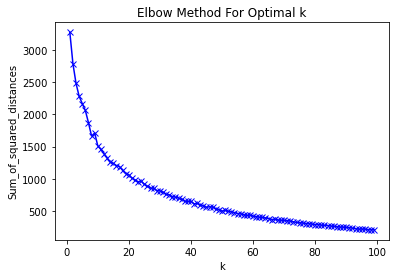

In [245]:
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cgr_clusters)
    Sum_of_squared_distances.append(km.inertia_)
    
import matplotlib.pyplot as plt
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [220]:
# add clustering labels
cgr_df4.insert(0, 'Cluster Labels', kmeans.labels_)
cgr_df4.head()

,Cluster Labels,CLASS,CLASS_CODE,COMM_CODE,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,...,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
NAME,,,,,,,,,,,,,,,,,,,,,
ABBEYDALE,0,Residential,1,ABB,NORTHEAST,BUILT-OUT,2000s,-113.927793,51.059517,"(51.05951675803878, -113.92779295314855)",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289000.0,0.097394,1.0
ACADIA,0,Residential,1,ACA,SOUTH,BUILT-OUT,1960s/1970s,-114.053702,50.972407,"(50.97240723913144, -114.05370183693996)",...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386000.0,0.156463,3.0
ALBERT PARK/RADISSON HEIGHTS,1,Residential,1,ALB,EAST,BUILT-OUT,1950s,-113.996784,51.044542,"(51.044541877637144, -113.99678381391571)",...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,299000.0,0.254966,2.0
ALPINE PARK,0,Residential,1,ALP,SOUTH,DEVELOPING,BUILDING OUT,-114.146538,50.917037,"(50.91703683139524, -114.1465381093008)",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700500.0,NaN,NaN
ALTADORE,0,Residential,1,ALT,CENTRE,BUILT-OUT,INNER CITY,-114.101859,51.015953,"(51.01595331908715, -114.10185887615782)",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,721000.0,0.085134,3.0


<h6>Visualizing the resulting clusters - NOTE: MAPS MAY NOT SHOW UP ON GITHUB DUE TO JavaScript restrictions on the site</h6>

In [221]:
cgr_df4.reset_index(inplace=True)
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cgr_df4['latitude'], cgr_df4['longitude'], cgr_df4['NAME'], cgr_df4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [222]:
cgr_feat1.insert(0, 'Cluster Labels', kmeans.labels_)
cgr_feat1.groupby('Cluster Labels').mean()

,Bank,Café,Coffee Shop,Convenience Store,Fast Food Restaurant,Gas Station,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
Cluster Labels,,,,,,,,,,,,,,,,
0,0.119403,0.164179,0.708955,0.373134,0.141791,0.261194,0.253731,0.089552,0.425373,0.261194,0.328358,0.067164,0.0,5.546224e+05,0.063963,1.037313
1,0.644068,0.237288,1.864407,1.101695,1.305085,1.084746,1.305085,0.271186,0.271186,0.813559,1.322034,0.016949,0.0,3.868178e+05,0.145116,1.559322
2,0.352941,2.823529,5.352941,0.352941,0.529412,0.235294,1.058824,1.000000,2.529412,0.764706,1.764706,0.000000,0.0,4.013235e+05,0.267883,0.823529
3,0.000000,0.000000,2.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,0.0,2.426833e+07,0.077225,0.333333
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,1.4,2.313000e+05,0.008442,0.000000


<h6>Examining the clusters</h6>

<h6 style="color:red">CLUSTER 0 - RED CLUSTER POINTS</h6>
<h7>Characteristics : <br>
A large number of communities fall into this cluster - 134 out of 218. <br>
Atleast 1 or more schools, low crime per capita, most common venues can be found close by but seems to be less than other communities, property rates higher than others </h7>

In [230]:
cgr_df4.loc[cgr_df4['Cluster Labels'] == 0, cgr_df4.columns[[0] + list(range(5, cgr_df4.shape[1]))]]

,NAME,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,Bank,Café,Coffee Shop,...,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
0,ABBEYDALE,NORTHEAST,BUILT-OUT,2000s,-113.927793,51.059517,"(51.05951675803878, -113.92779295314855)",0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289000.0,0.097394,1.0
1,ACADIA,SOUTH,BUILT-OUT,1960s/1970s,-114.053702,50.972407,"(50.97240723913144, -114.05370183693996)",0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386000.0,0.156463,3.0
3,ALPINE PARK,SOUTH,DEVELOPING,BUILDING OUT,-114.146538,50.917037,"(50.91703683139524, -114.1465381093008)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700500.0,NaN,NaN
4,ALTADORE,CENTRE,BUILT-OUT,INNER CITY,-114.101859,51.015953,"(51.01595331908715, -114.10185887615782)",0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,721000.0,0.085134,3.0
5,AMBLETON,NORTH,DEVELOPING,BUILDING OUT,-114.112071,51.186884,"(51.18688436617133, -114.11207075728163)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,WINDSOR PARK,CENTRE,BUILT-OUT,1950s,-114.083550,51.005040,"(51.005040465360054, -114.08354950733718)",1.0,1.0,4.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,204750.0,0.130890,NaN
213,WINSTON HEIGHTS/MOUNTVIEW,CENTRE,BUILT-OUT,1950s,-114.041857,51.075324,"(51.075323847960604, -114.04185722666399)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480000.0,0.166667,2.0
215,WOODBINE,SOUTH,BUILT-OUT,1980s/1990s,-114.129615,50.941348,"(50.94134763593498, -114.1296152823266)",0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,419000.0,0.041394,1.0
216,WOODLANDS,SOUTH,BUILT-OUT,1980s/1990s,-114.106339,50.942876,"(50.94287588247354, -114.10633945400146)",0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,413000.0,0.078640,2.0


<h6 style="color:purple">CLUSTER 1 - VIOLET CLUSTER POINTS</h6>
<h7>Characteristics : <br>
59 out of 218 communities fall into this category, majority are built-out communities.<br>
1 or more schools available<br>
Coffee shops, grocery stores, convenience stores, pizza places very commonly available in these communities.<br>
Property rates are low.<br>
Crime is higher than in other community clusters except for the city center </h7>

In [231]:
cgr_df4.loc[cgr_df4['Cluster Labels'] == 1, cgr_df4.columns[[0] + list(range(5, cgr_df4.shape[1]))]]

,NAME,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,Bank,Café,Coffee Shop,...,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
2,ALBERT PARK/RADISSON HEIGHTS,EAST,BUILT-OUT,1950s,-113.996784,51.044542,"(51.044541877637144, -113.99678381391571)",1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,299000.0,0.254966,2.0
7,ARBOUR LAKE,NORTHWEST,BUILT-OUT,NaN,-114.207694,51.132586,"(51.13258613113044, -114.20769360286123)",2.0,2.0,2.0,...,2.0,1.0,0.0,1.0,1.0,0.0,0.0,429500.0,0.079165,2.0
11,BANKVIEW,CENTRE,BUILT-OUT,INNER CITY,-114.100947,51.034133,"(51.03413275094789, -114.10094728849776)",0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,216500.0,0.228501,NaN
20,BRAESIDE,SOUTH,BUILT-OUT,1960s/1970s,-114.106353,50.955990,"(50.95599032588545, -114.10635315605607)",1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,362250.0,0.058205,1.0
21,BRENTWOOD,NORTHWEST,BUILT-OUT,1960s/1970s,-114.132464,51.096654,"(51.0966539228665, -114.13246381166202)",1.0,0.0,2.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,466500.0,0.121835,5.0
22,BRIDGELAND/RIVERSIDE,CENTRE,BUILT-OUT,INNER CITY,-114.035074,51.050566,"(51.050566015095384, -114.03507442166087)",0.0,1.0,2.0,...,2.0,1.0,0.0,0.0,2.0,1.0,0.0,269000.0,0.213753,1.0
23,BRIDLEWOOD,SOUTH,BUILT-OUT,2000s,-114.109727,50.899455,"(50.89945469209499, -114.10972685384392)",0.0,0.0,3.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,352500.0,0.035804,1.0
27,CAPITOL HILL,CENTRE,BUILT-OUT,1950s,-114.094650,51.072666,"(51.07266624510559, -114.09465000099681)",1.0,0.0,6.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,544500.0,0.140809,1.0
29,CASTLERIDGE,NORTHEAST,BUILT-OUT,1980s/1990s,-113.961030,51.105257,"(51.10525737274135, -113.961029784231)",2.0,0.0,1.0,...,3.0,0.0,1.0,1.0,1.0,0.0,0.0,311000.0,0.078750,1.0
30,CEDARBRAE,SOUTH,BUILT-OUT,1960s/1970s,-114.129616,50.957155,"(50.95715461568144, -114.12961609228238)",1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,346000.0,0.057926,1.0


<h6 style="color:#1ac6ff">CLUSTER 2 - BLUE CLUSTER POINTS</h6>
<h7>Characteristics : <br>
17 out of 218 communities fall into this category, all are built out and located in the center of the city<br>
Fewer schools available in these communities<br>
Plenty of cafes, parks and pizza places around.<br>
Property rates are the second highest as compared to the other clusters.<br>
Per capita Crime is highest here</h7>

In [233]:
cgr_df4.loc[cgr_df4['Cluster Labels'] == 2, cgr_df4.columns[[0] + list(range(5, cgr_df4.shape[1]))]]

,NAME,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,Bank,Café,Coffee Shop,...,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
16,BELTLINE,CENTRE,BUILT-OUT,CENTRE CITY,-114.055186,51.037450,"(51.0374499480811, -114.0551861089423)",0.0,1.0,5.0,...,1.0,2.0,5.0,1.0,0.0,0.0,0.0,165500.0,0.394047,3.0
33,CHINATOWN,CENTRE,BUILT-OUT,CENTRE CITY,-114.062532,51.050859,"(51.0508587163953, -114.06253246308364)",0.0,3.0,9.0,...,0.0,1.0,3.0,1.0,0.0,0.0,0.0,292500.0,0.121813,NaN
38,CLIFF BUNGALOW,CENTRE,BUILT-OUT,INNER CITY,-114.074891,51.033930,"(51.03392992166134, -114.07489081955826)",1.0,4.0,8.0,...,1.0,3.0,3.0,1.0,5.0,0.0,0.0,241000.0,0.513274,1.0
49,CRESCENT HEIGHTS,CENTRE,BUILT-OUT,INNER CITY,-114.061612,51.059520,"(51.05952005000434, -114.06161236711542)",1.0,3.0,2.0,...,1.0,2.0,3.0,1.0,2.0,0.0,0.0,288500.0,0.184894,1.0
59,DOWNTOWN COMMERCIAL CORE,CENTRE,BUILT-OUT,CENTRE CITY,-114.069590,51.047270,"(51.04727013236215, -114.06959026874493)",0.0,2.0,3.0,...,0.0,1.0,3.0,0.0,1.0,0.0,0.0,99500.0,0.846597,1.0
60,DOWNTOWN EAST VILLAGE,CENTRE,BUILT-OUT,CENTRE CITY,-114.050817,51.047065,"(51.04706481724879, -114.05081700333886)",1.0,1.0,13.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,237000.0,0.608528,NaN
61,DOWNTOWN WEST END,CENTRE,BUILT-OUT,CENTRE CITY,-114.087788,51.047966,"(51.047966240305676, -114.08778794453976)",0.0,4.0,4.0,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,34000.0,0.161221,NaN
63,EAU CLAIRE,CENTRE,BUILT-OUT,CENTRE CITY,-114.072823,51.053609,"(51.053609045056454, -114.07282264096536)",1.0,6.0,1.0,...,1.0,1.0,5.0,0.0,0.0,0.0,0.0,34000.0,0.245813,NaN
68,ERLTON,CENTRE,BUILT-OUT,INNER CITY,-114.063143,51.026329,"(51.02632870101975, -114.06314254063987)",0.0,1.0,4.0,...,1.0,1.0,3.0,1.0,1.0,0.0,0.0,306500.0,0.171911,NaN
91,HILLHURST,CENTRE,BUILT-OUT,INNER CITY,-114.093661,51.057268,"(51.05726814933771, -114.09366092967078)",0.0,3.0,5.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,432500.0,0.213120,3.0


<h6 style="color:#80ff80">CLUSTER 3 - GREEN CLUSTER POINTS</h6>
<h7>Characteristics : <br>
3 out of 218 communities fall into this category, all around the university area.<br>
Very few schools available in these communities<br>
Some coffee shops are available.<br>
Property rates do not appear to be affordable.<br>
Per capita Crime is very low here</h7>

In [234]:
cgr_df4.loc[cgr_df4['Cluster Labels'] == 3, cgr_df4.columns[[0] + list(range(5, cgr_df4.shape[1]))]]

,NAME,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,Bank,Café,Coffee Shop,...,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
146,QUEENS PARK VILLAGE,CENTRE,BUILT-OUT,1950s,-114.077609,51.085147,"(51.08514667909161, -114.07760880424992)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31080000.0,0.123077,NaN
198,UNIVERSITY DISTRICT,NORTHWEST,BUILT-OUT,OTHER,-114.144949,51.073857,"(51.07385742333148, -114.14494935038472)",0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12675000.0,NaN,1.0
200,UNIVERSITY OF CALGARY,NORTHWEST,BUILT-OUT,OTHER,-114.129917,51.075012,"(51.07501240644861, -114.1299167839167)",0.0,0.0,5.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,29050000.0,0.108597,NaN


<h6 style="color:#ffb366">CLUSTER 4 - ORANGE CLUSTER POINTS</h6>
<h7>Characteristics : <br>
5 out of 218 communities fall into this category, all around outskirts of the city and developing comunities.<br>
There are no schools here<br>
There are no grocery stores or other useful venues around.<br>
Property rates are very affordable.<br>
Per capita Crime is very very low here</h7>

In [235]:
cgr_df4.loc[cgr_df4['Cluster Labels'] == 4, cgr_df4.columns[[0] + list(range(5, cgr_df4.shape[1]))]]

,NAME,SECTOR,SRG,COMM_STRUCTURE,longitude,latitude,location,Bank,Café,Coffee Shop,...,Grocery Store,Gym / Fitness Center,Park,Pharmacy,Pizza Place,Playground,Real Estate Office,ASSESSED_VALUE,CRIME_PER_CAPITA_2019,NUM_SCHOOLS
15,BELMONT,SOUTH,DEVELOPING,BUILDING OUT,-114.055280,50.868746,"(50.8687461630655, -114.05528026129238)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,211500.0,NaN,NaN
43,CORNERSTONE,NORTHEAST,DEVELOPING,2000s,-113.930582,51.157369,"(51.157369070418774, -113.93058203535684)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,286000.0,NaN,NaN
104,LEGACY,SOUTH,DEVELOPING,BUILDING OUT,-114.005999,50.857617,"(50.8576170329455, -114.0059990060311)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,215500.0,0.042212,NaN
142,PINE CREEK,SOUTH,DEVELOPING,BUILDING OUT,-114.067879,50.856263,"(50.85626272703566, -114.06787924014992)",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,132000.0,NaN,NaN
214,WOLF WILLOW,SOUTH,DEVELOPING,BUILDING OUT,-114.008637,50.870724,"(50.870724299120106, -114.00863678779113)",0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,311500.0,NaN,NaN


In [236]:
cgr_df4.to_excel('final_df_with_cluster_labels.xlsx')